<a href="https://colab.research.google.com/github/A01793509/Equipo38/blob/main/MNA_IAyAA_semana_7_Actividad_r2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Inteligencia Artificial y Aprendizaje Automático**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## **Adtividad de la Semana 7**
###**Red Neuronal Artificial - Perceptrón Multicapa : Multilayer Perceptrón (MLP)**


**Nombres y matrículas de los integrantes del equipo:**

*   Alberto Jose Garcia Porras (A01793509)
*   Carlos Julio León Caicedo (A01793947)
*   Luis Fernando Ríos Piedra (A00453954)
*   Marco Antonio Vázquez Morales (A01793704)

En cada sección deberás incluir todas las líneas de código necesarias para responder a cada uno de los ejercicios.

#**Contexto del problema y el conjunto de datos a utilizar**

El objetivo es determinar el impacto generado por un anuncio de una marca de cosméticos en Facebook, en el cual se intentaron varias variantes en la manera de mostrar el anuncio. Siguiendo el [artículo](https://www.semanticscholar.org/paper/Predicting-social-media-performance-metrics-and-of-Moro-Rita/dec55692590820754b53c916e29bb2b42c0e5104), deberás considerar como predictores o variables de entrada aquellas que se indican en la Tabla 3. Por otro lado, en la Tabla 2, los autores consideran varios casos para la variable de salida, intentando determinar cuál puede ser el mejor caso para medir el éxito de la campaña. Para este ejercicio deberás considerar únicamente los siguientes tres casos como variable de salida: “Lifetime post consumers”, “Lifetime People who have liked a Page and engaged with a post” y “Likes”. 

El conjunto de datos a utilizar es el de la siguiente liga de la UCI:
https://archive.ics.uci.edu/ml/datasets/Facebook+metrics


In [48]:
# Incluye aquí todos módulos, librerías y paquetes que requieras.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, zipfile
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer,classification_report
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from io import BytesIO

from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.ensemble import BalancedRandomForestClassifier

#**Ejercicio-1.** 

En esta tarea considera únicamente la siguiente variable de salida que se concluye que es una de las mejores en el artículo antes citado:  ‘Lifetime People who have liked a Page and engaged with a post'. Renombra dicha variable como “LPE”. Como variables de entrada selecciona las 7 variables que indican los autores en la Tabla 3 del artículo citado.


In [2]:
path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip'
base_datos = path.split('/')[-1]
req_path = requests.get(path)

archivo_uci= zipfile.ZipFile(BytesIO(req_path.content))
archivo_uci.extractall('/content/sample_data/Facebook_metrics')
df = pd.read_csv("/content/sample_data/Facebook_metrics/dataset_Facebook.csv",sep=';')

df.rename(columns={'Lifetime People who have liked your Page and engaged with your post':'LPE'},
               inplace=True)
df.tail()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,LPE,comment,like,share,Total Interactions
495,85093,Photo,3,1,7,2,0.0,4684,7536,733,708,985,4750,2876,392,5,53.0,26.0,84
496,81370,Photo,2,1,5,8,0.0,3480,6229,537,508,687,3961,2104,301,0,53.0,22.0,75
497,81370,Photo,1,1,5,2,0.0,3778,7216,625,572,795,4742,2388,363,4,93.0,18.0,115
498,81370,Photo,3,1,4,11,0.0,4156,7564,626,574,832,4534,2452,370,7,91.0,38.0,136
499,81370,Photo,2,1,4,4,NaN,4188,7292,564,524,743,3861,2200,316,0,91.0,28.0,119


In [3]:
#Llenado de dato único dato nulo encontrado
df['Paid']=df['Paid'].fillna(0)

In [4]:
#Separación de variables numéricas y categóricas del df original
#Creación de dummies para variable Type
df_nums = df.select_dtypes(exclude='object')
df_objs = df.select_dtypes(include='object')
df_objs = pd.get_dummies(df_objs,drop_first=True)
final_df = pd.concat([df_nums,df_objs],axis=1)
final_df.columns

Index(['Page total likes', 'Category', 'Post Month', 'Post Weekday',
       'Post Hour', 'Paid', 'Lifetime Post Total Reach',
       'Lifetime Post Total Impressions', 'Lifetime Engaged Users',
       'Lifetime Post Consumers', 'Lifetime Post Consumptions',
       'Lifetime Post Impressions by people who have liked your Page',
       'Lifetime Post reach by people who like your Page', 'LPE', 'comment',
       'like', 'share', 'Total Interactions', 'Type_Photo', 'Type_Status',
       'Type_Video'],
      dtype='object')

In [5]:
#Generar df con variables finales para el modelo
var_input=final_df[['Category', 'Page total likes', 'Type_Photo', 'Type_Status',
       'Type_Video', 'Post Month', 'Post Hour', 'Post Weekday', 'Paid','LPE']]
# print(df[['Category', 'Page total likes', 'Type', 'Post Month', 'Post Hour', 'Post Weekday', 'Paid']])


In [6]:
# Definimos los atributos de entrada como 'X' y a la variable de salida como 'Y'
# Para este ejercicio deberás considerar únicamente los siguientes tres casos como variable de salida: 
# “Lifetime post consumers”, “Lifetime People who have liked a Page and engaged with a post” y “Likes”.

X = var_input.drop('LPE',axis=1)
y = var_input['LPE']

#Variables de salida de la Tabla 2, los autores consideran varios casos para la variable de salida
# Y=df['Lifetime post total reach','Lifetime post total impressions','Lifetime engaged users','Lifetime post consumers',
#      'Lifetime post consumotions','Lifetime post impressions by people who have liked a page','Lifetime post reach by people who like a page'
#      'Lifetime people who have liked a page and engaged with a post','Comments','Likes','Shares','Total interactions']

#**Ejercicio-2.**

Realiza una partición de los datos con 100 datos de Prueba y el resto para entrenamiento y validación.

In [ ]:
# # Definimos los atributos de entrada como 'X' y a la variable de salida como 'Y'
# # Para este ejercicio deberás considerar únicamente los siguientes tres casos como variable de salida: 
# # “Lifetime post consumers”, “Lifetime People who have liked a Page and engaged with a post” y “Likes”.

# var_otput = ['LPE']
# X = df[var_input]
# Y = df[var_otput]

# #Variables de salida de la Tabla 2, los autores consideran varios casos para la variable de salida
# # Y=df['Lifetime post total reach','Lifetime post total impressions','Lifetime engaged users','Lifetime post consumers',
# #      'Lifetime post consumotions','Lifetime post impressions by people who have liked a page','Lifetime post reach by people who like a page'
# #      'Lifetime people who have liked a page and engaged with a post','Comments','Likes','Shares','Total interactions']

In [14]:
#Partición de datos, test_size=100*100/500= 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)
#X_train.info()
#Ytrain.info()

In [17]:
X_train.shape

(400, 9)

#**Ejercicio-3.**
Definirás tus propias funciones de errores para este problema de regresión. Los errores que utilizarás son la raíz cuadrada del error cuadrático medio RMSE, el error absoluto medio MAE y el error porcentual absoluto medio MAPE.

In [18]:
#Definiendo función RMSE
def mi_RMSE(y_val,yhatVal):
  return np.mean(np.sqrt(np.abs(y_val-yhatVal)))
#Definiendo función MAE
def mi_MAE(y_val,yhatVal):
  return np.mean(np.abs(y_val-yhatVal))
#Definiendo función MAPE
def mi_MAPE(y_val,yhatVal):
  return np.mean(np.abs((y_val-yhatVal)/y_val))*100

#**Ejercicio-4.**
En la página de la UCI, así como en el artículo de los autores previamente citado encuentras información en relación al significado de cada variable. Haz una análisis de tus datos y lleva a cabo las transformaciones que consideres adecuadas tanto en los datos de entrada, como en las de salida.
Utiliza un Pipeline para evitar el filtrado de información.


In [25]:
# Transformaciones a factores numéricos de entrada:
num_pipe = Pipeline(steps = [('impMediana', SimpleImputer(strategy='median')),
                                 ('escalaNum', MinMaxScaler(feature_range=(1,2)))])   
num_pipe_nombres = [ 'Page total likes']

# Transformaciones a factores categóricos de entrada:
catImp_pipe = Pipeline(steps = [('impModa', SimpleImputer(strategy='most_frequent'))])  
catImp_pipe_nombres = ['Category', 'Page total likes', 'Type_Photo', 'Type_Status',
       'Type_Video', 'Post Month', 'Post Hour', 'Post Weekday','Paid']

catOHE_pipe = Pipeline(steps = [('OneHotE', OneHotEncoder(drop='first'))])
catOHE_pipe_nombres = ['Type_Photo', 'Type_Status',
       'Type_Video','Paid']


# Conjuntamos las transformaciones numéricas y categóricas que se estarán aplicando a los datos de entrada:
columnasTransformer = ColumnTransformer(transformers = [('numpipe', num_pipe, num_pipe_nombres),
                                                        ('catimp', catImp_pipe, catImp_pipe_nombres),
                                                        ('catohe', catOHE_pipe, catOHE_pipe_nombres)],
                                        remainder='passthrough')

#**Ejercicio-5.**
Utiliza la función Dummy para modelos de regresión de scikit-learn con el conjunto que tienes de datos de entrenamiento y validación. Para ello particiónalos en 100 para validación y 300 para entrenamiento. Encuentra los errores RMSE, MAE y MAPE para los conjuntos de entrenamiento y validación. 

Estos serán tus errores máximos que deberás tomar como referencia en el resto de la actividad. Consulta su documentación correspondiente: https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html

In [26]:
#Partición de datos, test_size=100*100/400= 25%
Xtrain, X_val, ytrain, y_val = train_test_split(X_train, y_train, test_size=.25)

In [27]:
from sklearn.dummy import DummyClassifier 

modeloDummy = DummyClassifier(strategy='uniform', random_state=11)  

modeloDummy.fit(Xtrain, ytrain)  
yhat = modeloDummy.predict(X_val)

print('Valor de RMSE a superar: %.4f' % mi_RMSE(y_val,yhat))
print("Valor del MAE a superar: %.4f" % mi_MAE(y_val,yhat))
print("Valor del MAPE a superar: %.4f" % mi_MAPE(y_val,yhat))

Valor de RMSE a superar: 19.6084
Valor del MAE a superar: 518.0800
Valor del MAPE a superar: 121.0257


#**Ejercicio-6.**
Usando los modelos de regresión lineal múltiple, el bosque aleatorio y el perceptrón multicapa con sus valores predeterminados, lleva a cabo su entrenamiento con repeticiones de validación cruzada (RepeatedKFold) y desplegando los errores RMSE, MAE y MAPE. Recuerda evitar el filtrado de
información usando los datos que obtuviste en el ejercicio 2. Incluye las conclusiones sobre el mejor modelo encontrado en esta primera aproximación. En particular ¿hay alguno sobreentrenado o subentrenado? NOTA: Recuerda que puedes aumentar en dado caso el número máximo de iteraciones para que todos los modelos converjan.

In [60]:
def get_models():
  modelos = list()
  nombres = list()

  # LR - Regresión Lineal Multiiple:
  modelos.append(LinearRegression())
  nombres.append('LLM')

  # DT - Bosque Aleatorio:
  modelos.append(RandomForestClassifier())
  nombres.append('RF')
  
  # MLP - Red Neuronal Artificial / Perceptrón Lineal Multicapa:  
  modelos.append(MLPClassifier(hidden_layer_sizes=(30,), max_iter=3000))
  nombres.append('MLP')
  
  
  return modelos, nombres

In [71]:
modelos, nombres = get_models()
resultados = list() 

scores_RMSEVal = []
scores_MAEVal = []
scores_MAPEVal = []

#cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3)

cv = KFold(n_splits= 3, shuffle=True)

for m in range(len(modelos)):

  for train_index, val_index in cv.split(X_train):

    modelo=modelos[m]

    XtrainFit = columnasTransformer.fit(X_train)   
    XtrainTransf = XtrainFit.transform(X_train)    

    modelo = modelo.fit(XtrainTransf, y_train) 

    XvalTransf = XtrainFit.transform(X_val) 
    yhatVal = modelo.predict(XvalTransf)  

    scores_RMSEVal.append(mi_RMSE(y_val, yhatVal))
    scores_MAEVal.append(mi_MAE(y_val, yhatVal))
    scores_MAPEVal.append(mi_MAPE(y_val, yhatVal))


# Desplegar información:
resultados = [scores_RMSEVal, scores_MAEVal, scores_MAPEVal]
names = ['RMSE','MAE','MAPE']

print("\t  %s\t\t%s   \t\t%s" % (names[0],names[1],names[2]))
#for i,z in enumerate(zip(scores_RMSEVal, scores_MAEVal, scores_MAPEVal)):
#  print("fold[%d]:  %.1f \t\t%.1f  \t\t%.1f%%" % (i+1,z[0],z[1],z[2]))
print("mean(std) %.1f(%.1f)    \t%.1f(%.1f)           \t%.1f%% (%.1f)" % (np.mean(scores_RMSEVal), np.std(scores_RMSEVal),
                                                                np.mean(scores_MAEVal), np.std(scores_MAEVal),
                                                                np.mean(scores_MAPEVal), np.std(scores_MAPEVal)))

	  RMSE		MAE   		MAPE
mean(std) 11.4(8.6)    	255.4(222.4)           	78.3% (85.9)


In [41]:
#modelos, nombres = get_models()  # cargamos los modelos a comparar
#resultados = list()   

#for i in range(len(modelos)):

#  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])

#  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

#**Ejercicio-7.**
Obtener los diagramas de caja y bigote para los errores MAPE de los conjuntos de validación obtenidos. En particular compara estos primeros resultados de MAPE con el mejor resultado que encuentran los autores del artículo citado al inicio. Incluye tus conclusiones.

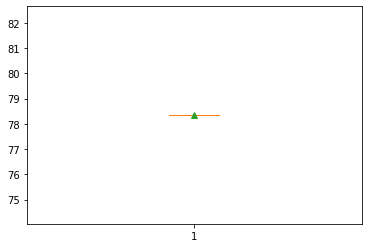

In [72]:
plt.boxplot(np.mean(scores_MAPEVal), labels=None, showmeans=True)
plt.show()

#**Ejercicio-8.**

Usando una búsqueda de malla con validación cruzada (GridSearchCV), busca los mejores hiperparámetros para el modelo MLP. Al menos deberás realizar la búsqueda en los hiperparámetros “hidden_layer_sizes”, “alpha” y “learning_rate_init”. Además aplica la validación cruzada con repeticiones (RepeatedKFold). Muestra los mejores hiperparámetros encontrados.

In [ ]:
None

#**Ejercicio-9.**
Con los mejores valores de los hiperparámetros encontrados realiza un análisis de la importancia de los factores. Muestra un diagrama de barras de los resultados e incluye tus conclusiones.

In [ ]:
None

#**Ejercicio-10.**
Repite el ejercicio 8 y 9 para el modelo de bosque aleatorio para buscar sus mejores hiperparámetros (realiza la búsqueda con aquellos hiperparámetros que consideres más adecuados) y usando el conjunto de Prueba. Y realiza igualmente el análisis de importancia de factores con este modelo con un diagrama de barras.

In [ ]:
None

#**Ejercicio-11.**
Repite el ejercicio 8 y 9 para el modelo de regresión lineal múltiple para buscar sus mejores hiperparámetros (realiza la búsqueda con aquellos hiperparámetros que consideres más adecuados) y usando el conjunto de Prueba. Y realiza igualmente el análisis de importancia de factores con este modelo con un diagrama de barras.

In [ ]:
None

#**Ejercicio-12.**
Compara tus resultados con los obtenidos por los autores del artículo de Moro-Rita-Vala con respecto a MAPE. Incluye tus conclusiones finales de la actividad.


In [ ]:
None

###**Fin de la Actividad de la semana 7.**